In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install openai docx2txt transformers bert-score --upgrade --quiet

## Import the modules and define the variables

In [ ]:
import os
import shutil
import json
import time
from tqdm.notebook import tqdm

import zipfile
import docx2txt

import pandas as pd

from openai import OpenAI
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

In [ ]:
os.environ["OPENAI_API_KEY"] = ""
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

In [ ]:
scorer = BERTScorer(lang="en")

## The Dataset - Transcripts and the human generated summaries

In [ ]:
# !rm -rf /content/few_shot_training_data/

In [ ]:
# If the dataset is in zip format

dataset_paths = ['/content/few shot training data.zip']
directory_to_extract_to = '/content'

for path_to_zip_file in dataset_paths:
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [ ]:
# shutil.rmtree('/content/few shot training data/human video w- reading summaries/.ipynb_checkpoints')

In [ ]:
print('Size of the dataset:', len(os.listdir('/content/few shot training data/human video w- reading summaries')))

Size of the dataset: 17


### Clean the dataset folder

In [ ]:
# text_files = os.listdir('/content/dataset/text')
# summaries = os.listdir('/content/dataset/human generated summaries')

In [ ]:
# os.mkdir('/content/dataset/transcripts')

In [ ]:
# for files in summaries:
#     shutil.copyfile('/content/dataset/text/'+files[:-13]+'.txt', '/content/dataset/transcripts/'+files[:-13]+'.txt')

### Load to a dataframe

In [ ]:
def load_to_dataframe(path_to_transcript, path_to_reading_material, path_to_human_summary):

    data = pd.DataFrame(columns=['transcript', 'reading_material', 'human_summary'])

    summary_files = os.listdir(path_to_human_summary)
    transcript_list = []
    summary_list = []
    reading_list = []

    for files in summary_files:
        transcript_files = str(files[:-4]+'__transcript.txt').replace(' ', '_')
        reading_files = str(files[:-4]+'_rm.txt').replace(' ', '_')

        summ_files = os.path.join(path_to_human_summary, files)
        transcript_files = os.path.join(path_to_transcript, transcript_files)
        reading_files = os.path.join(path_to_reading_material, reading_files)

        with open(summ_files, 'r') as fp:
            summary_list.append(fp.read())

        with open(transcript_files, 'r') as fp:
            transcript_list.append(fp.read())

        with open(reading_files, 'r') as fp:
            reading_list.append(fp.read())

    data['transcript'] = pd.Series(transcript_list)
    data['reading_material'] = pd.Series(reading_list)
    data['human_summary'] = pd.Series(summary_list)

    return data

In [ ]:
path_to_transcript = '/content/few shot training data/transcript text/'
path_to_human_summary = '/content/few shot training data/human video w- reading summaries'
path_to_reading_material = '/content/few shot training data/reading material'

In [ ]:
data = load_to_dataframe(path_to_transcript, path_to_reading_material, path_to_human_summary)

In [ ]:
data

,transcript,reading_material,human_summary
0,Welcome to the WebAudio API lesson! I personna...,HTML5 Audio is a subject of the HTML5 specific...,The Web Audio API specification developed by W...
1,in this video I'm going to define whether it's...,Supervised learning (SL) is a paradigm in mach...,"﻿Supervised learning, formally, is a machine l..."
2,Our story begins 20 years ago. Boris Yeltsin w...,Linux ( LIN-uuks) is a family of open-source U...,"In 1991, Linus Torvalds created Linux, an open..."
3,in this video we'll talk about the second majo...,Unsupervised learning is a method in machine l...,﻿Unsupervised learning is a method in machine ...
4,"Hi I’m Carrie Anne, this is Crash Course Compu...",A computer number format is the internal repre...,Computers are complex systems which require me...
5,our first learning algorithm will be linear re...,"In statistics, simple linear regression (SLR) ...",﻿Linear regression plays an important role in ...
6,what this machine learning in this video we wi...,Machine learning (ML) is a field of study in a...,﻿Machine learning is a field of study in artif...
7,"Hi, I'm Carrie Anne and welcome to Crash Cours...",A programming language is a system of notation...,﻿Computers today use complex circuits in order...
8,"Hi, I’m Carrie Anne and this is Crash Course C...","In computer programming, machine code is compu...","﻿CPUs combine an ALU, control unit, memory, an..."
9,"Hello world, I’m Carrie Anne, and welcome to C...",The history of computing hardware covers the d...,﻿Computers have become essential for various a...


## Zero shot learning

In [ ]:
def get_prompt(row):
    return [
        {"role": "system", "content": "Zero shot model."},
        {
            "role": "user",
            "content": f"""
                          Please write a 500 word summary on the following Transcript based on the Reading Material.
                          Pick relevant information from the Reading Material and add it to the summary of the Transcript.
                          The Summary should be only of the Transcript with a few information from the Reading Material.
                          If you are not sure of the summary, say 'I don't know'.

                          Transcript: {row.transcript}\n\n
                          Reading Material: {row.reading_material}\n\n
                          Answer:\n""",
        },
    ]

In [ ]:
# def get_prompt(row):
#     return [
#         {"role": "system", "content": "Zero shot model."},
#         {
#             "role": "user",
#             "content": f"""can you summarise a Transcript for me? The summary has to be 500 words long""",
#         },
#         {
#             "role": "user",
#             "content": f"""Transcript: {row.transcript}""",
#         },
#         {
#             "role": "user",
#             "content": f"""Can you enhance the previous generated summary with the help of Reading Material? Pick some contents from the
#                            Reading Material which are relevant to the concepts discussed in the Transcript.
#                            Let the enhanced summary be 600 words""",
#         },
#         {
#             "role": "user",
#             "content": f"""Reading Material: {row.transcript}""",
#         },
#     ]

In [ ]:
def api_call(messages, model):
    return client.chat.completions.create(
        model=model,
        messages=messages
    )


# Main function to answer question
def generate_summary(row, prompt_func=get_prompt, model="gpt-3.5-turbo"):
    messages = prompt_func(row)
    response = api_call(messages, model)
    return response.choices[0].message.content

In [ ]:
zero_shot_model_summ = generate_summary(data.iloc[0])

In [ ]:
print(zero_shot_model_summ)

In [ ]:
human_summ = data.iloc[0]['human_summary']

In [ ]:
print(human_summ)

In [ ]:
# scorer = BERTScorer(model_type='bert-base-uncased')
P, R, F1 = scorer.score([zero_shot_model_summ], [human_summ])
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

## Few Shot Learning

In [ ]:
def get_prompt_for_fine_tuning(row):
    return [
        {
            "role": "user",
            "content": f"""Transcript: {row.transcript}\n\n
                           Reading Material: {row.reading_material}\n\n
                           Answer: \n\n""",
        },
        {"role": "assistant", "content": row.human_summary},
    ]

def get_training_data(row):

    prompts = []
    instruction = '''
                      Please write a 500 word summary on the following Transcript based on the Reading Material.
                      Pick relevant information from the Reading Material and add it to the summary of the Transcript.
                      The Summary should be only of the Transcript with a few information from the Reading Material.
                      If you are not sure of the summary, say 'I don't know'.
    '''

    prompts += get_prompt_for_fine_tuning(row)

    prompts = [{"role": "system", "content": instruction}] + prompts
    return prompts

In [ ]:
data["few_shot_prompt"] = data.apply(get_training_data, axis=1)

In [ ]:
def dataframe_to_jsonl(df):

    def create_jsonl_entry(row):
        messages = row["few_shot_prompt"]
        return json.dumps({"messages": messages})

    jsonl_output = df.apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

with open("17_train_few_shot.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(data))

### OpenAI Fine Tuning

In [ ]:
class OpenAIFineTuner:
    """
    Class to fine tune OpenAI models
    """
    def __init__(self, training_file_path, model_name, suffix):
        self.training_file_path = training_file_path
        self.model_name = model_name
        self.suffix = suffix
        self.file_object = None
        self.fine_tuning_job = None
        self.model_id = None

    def create_openai_file(self):
        self.file_object = client.files.create(
            file=open(self.training_file_path, "rb"),
            purpose="fine-tune",
        )

    def wait_for_file_processing(self, sleep_time=45):
        while self.file_object.status != 'processed':
            time.sleep(sleep_time)
            self.file_object.refresh()
            print("File Status: ", self.file_object.status)

    def create_fine_tuning_job(self):
        self.fine_tuning_job = client.fine_tuning.jobs.create(
            training_file=self.file_object.id,
            model=self.model_name,
            suffix=self.suffix,
        )

    def wait_for_fine_tuning(self, sleep_time=45):
        i = 1
        while self.fine_tuning_job.status != 'succeeded':
            time.sleep(sleep_time)
            self.fine_tuning_job = client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id)
            print("Time: ", i*45, "s, Job Status: ", self.fine_tuning_job.status)
            i += 1

    def retrieve_fine_tuned_model(self):
        self.model_id = self.fine_tuning_job.fine_tuned_model
        return self.model_id

    def fine_tune_model(self):
        self.create_openai_file()
        self.wait_for_file_processing()
        self.create_fine_tuning_job()
        self.wait_for_fine_tuning()
        return self.retrieve_fine_tuned_model()

fine_tuner = OpenAIFineTuner(
        training_file_path="17_train_few_shot.jsonl",
        model_name="gpt-3.5-turbo-1106",
        suffix="17fewshot20240304"
    )

In [ ]:
model_id = fine_tuner.fine_tune_model()
model_id

Time:  45 s, Job Status:  running
Time:  90 s, Job Status:  running
Time:  135 s, Job Status:  running
Time:  180 s, Job Status:  running
Time:  225 s, Job Status:  running
Time:  270 s, Job Status:  running
Time:  315 s, Job Status:  running
Time:  360 s, Job Status:  running
Time:  405 s, Job Status:  running
Time:  450 s, Job Status:  running
Time:  495 s, Job Status:  succeeded


'ft:gpt-3.5-turbo-1106:ucsc:17fewshot20240304:8zHZ2yJ7'

#### Trained model ID:
model_id = 'ft:gpt-3.5-turbo-0125:ucsc:26fewshot20240302:8yOzIOdp'
model_id = 'ft:gpt-3.5-turbo-0125:ucsc:26fewshot20240302:8zFmJEY4'
model_id = 'ft:gpt-3.5-turbo-1106:ucsc:11fewshot20240304:8zG6iQyx'

## Validating the fine-tuned model

### On an existing transcript

In [ ]:
zero_shot_model_summ = generate_summary(data.iloc[3])

In [ ]:
few_shot_model_summ_11 = generate_summary(data.iloc[3], model='ft:gpt-3.5-turbo-1106:ucsc:11fewshot20240304:8zG6iQyx')

In [ ]:
few_shot_model_summ_17 = generate_summary(data.iloc[3], model='ft:gpt-3.5-turbo-1106:ucsc:17fewshot20240304:8zHZ2yJ7')

In [ ]:
print(zero_shot_model_summ)

The transcript discusses the concept of unsupervised learning, contrasting it with supervised learning where algorithms learn patterns from unlabeled data. Unsupervised learning involves finding structure in data without explicit guidance on what the correct answers are. Clustering algorithms are a popular unsupervised learning tool, used in various applications such as organizing news stories on Google News or grouping individuals based on genomics data.

The reading material provides additional insights into unsupervised learning methods such as neural networks, including discriminative and generative tasks. Hebbian learning principles, self-organizing maps, and adaptive resonance theory are also mentioned as common unsupervised learning methods. The reading material highlights probabilistic methods like clustering and anomaly detection as approaches used in unsupervised learning. The method of moments is discussed as a statistical approach for estimating unknown parameters in latent

In [ ]:
print(few_shot_model_summ_11)

Unsupervised learning is a method in machine learning where, in contrast to supervised learning, the machine learning algorithms learn patterns exclusively from unlabeled data. The algorithms learn patterns exclusively from unlabeled data and build a concise representation of its world, generating imaginative content from it. 

This method is particularly useful for tasks such as clustering, where the algorithm identifies inherent structures or groupings within a dataset without any prior knowledge. In machine learning, it is a way of teaching neural networks to mimic the ways that human brains learn and group data according to 
commonalities they see between inputs. This is also how we arrive at “creativity” in machine learning, where the machine learning model is trained to generate data from its concise representation. Applying this to audio input, we can use the clustering model to separate audio sources from a recording, for example, separating voices and music from an audio recor

In [ ]:
print(few_shot_model_summ_17)

Unsupervised learning is a method in machine learning where, in contrast to supervised learning, algorithms learn patterns exclusively from unlabeled data. The hope is that through mimicry, which is an important mode of learning in people, the machine is forced to build a concise representation of its world and then generate imaginative content from it. Unsupervised learning identifies commonalities in the data and reacts based on the presence or absence of such commonalities respond to feedback rather than explicitly look for patterns like we are clustering data.

One type of unsupervised learning algorithm is a clustering algorithm. Unsupervised learning can be used to automatically find structure in the data and automatically cluster individuals into these types that we don't know in advance using clustering algorithms. 

Some of the common applications of Unsupervised learning are:
	Organizing large computer clusters
	Social network analysis
	Market segmentation
	Understanding geno

In [ ]:
human_summ = data.iloc[3]['human_summary']

In [ ]:
P, R, F1 = scorer.score([zero_shot_model_summ], [human_summ])
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.8708, Recall: 0.8338, F1: 0.8519


In [ ]:
P, R, F1 = scorer.score([few_shot_model_summ_11], [human_summ])
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.8914, Recall: 0.8954, F1: 0.8934


In [ ]:
P, R, F1 = scorer.score([few_shot_model_summ_17], [human_summ])
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.8908, Recall: 0.8887, F1: 0.8898


### On a new transcript

In [ ]:
def load_all_to_dataframe(path_to_transcript, path_to_reading_material, path_to_human_summary):

    data = pd.DataFrame(columns=['transcript', 'reading_material', 'human_summary'])

    transcript_files = os.listdir(path_to_transcript)
    transcript_list = []
    summary_list = []
    reading_list = []

    for files in transcript_files:
        transcript_files = files
        reading_files = files[:-16]+'_rm.txt'
        summ_files = files[:-16]+'.txt'

        if summ_files in os.listdir(path_to_human_summary):
            summ_files = os.path.join(path_to_human_summary, summ_files)

            with open(summ_files, 'r') as fp:
                summary_list.append(fp.read())
        else:
            summary_list = ['']

        transcript_files = os.path.join(path_to_transcript, transcript_files)
        reading_files = os.path.join(path_to_reading_material, reading_files)

        with open(transcript_files, 'r') as fp:
            transcript_list.append(fp.read())

        with open(reading_files, 'r') as fp:
            reading_list.append(fp.read())

    data['transcript'] = pd.Series(transcript_list)
    data['reading_material'] = pd.Series(reading_list)
    data['human_summary'] = pd.Series(summary_list)

    return data

In [ ]:
data_all = load_all_to_dataframe(path_to_transcript, path_to_reading_material, path_to_human_summary)

In [ ]:
data_all

,transcript,reading_material,human_summary
0,in this video I'm going to define whether it's...,Supervised learning (SL) is a paradigm in mach...,
1,our first learning algorithm will be linear re...,"In statistics, simple linear regression (SLR) ...","﻿An ALU (Arithmetic and Logic Unit) is the ""ma..."
2,Welcome to the WebAudio API lesson! I personna...,HTML5 Audio is a subject of the HTML5 specific...,NaN
3,"Hi, I’m Carrie Anne and welcome to Crash Cours...","In mathematics and mathematical logic, Boolean...",NaN
4,Expression is a combination of objects and ope...,"Python is a high-level, general-purpose progra...",NaN
5,"Hi, I’m Carrie Anne and this is Crash Course C...","In computer programming, machine code is compu...",NaN
6,"Hi, I’m Carrie Anne and welcome to CrashCourse...","In electronics, computer science and computer ...",NaN
7,"Hi, I'm Carrie Anne and welcome to Crash Cours...",A programming language is a system of notation...,NaN
8,"You use Linux every day, whether you know it o...",Linux ( LIN-uuks) is a family of open-source U...,NaN
9,Our story begins 20 years ago. Boris Yeltsin w...,Linux ( LIN-uuks) is a family of open-source U...,NaN


In [ ]:
zero_shot_model_summ = generate_summary(data_all.iloc[4])

In [ ]:
print(zero_shot_model_summ)

The transcript discusses the concept of boolean data types in Python and explores boolean operations such as "or", "and", and "not". It explains how these operations work with True and False values, emphasizing the importance of capitalizing boolean type objects in Python. The transcript also delves into comparison operations in Python, highlighting that comparisons result in boolean types of True or False. It showcases examples of comparisons with numbers and lists, illustrating how Python determines equality and identity between objects. Furthermore, the transcript touches upon the distinction between object identity and object contents when comparing data structures like lists.

From the reading material, we understand that Python is a high-level programming language known for its readability and comprehensive standard library. Developed in the late 1980s by Guido van Rossum, Python supports multiple programming paradigms and is dynamically typed. It has gained popularity in various

In [ ]:
few_shot_model_summ_11 = generate_summary(data_all.iloc[4], model='ft:gpt-3.5-turbo-1106:ucsc:11fewshot20240304:8zG6iQyx')

In [ ]:
print(few_shot_model_summ_11)

Expression in Python is a combination of objects and operators that compute a value. The boolean data type represents only two values, True and False. In Python, boolean values must be capitalized as True and False. When performing operations involving logic, such as boolean operations, you use operators to return boolean values; there are three boolean operators: "or", "and", and "not" in Python.

Boolean operators:
- "or" returns True if either x is True or y is True, or both are True (e.g., True or False is True)
- "and" returns True only if both x and y are True (e.g., True and False is False)
- "not" negates the value of the object (e.g., not True is False)

Comparison operations:
- Used to compare objects, resulting in boolean values
- A total of eight different comparison operations in Python
- Commonly used for numeric types and applies to other types, carrying out element-wise comparisons between sequences

Example of numeric comparisons:
- '=' Tests for equality
- '<'	Strictl

In [ ]:
few_shot_model_summ_17 = generate_summary(data_all.iloc[4], model='ft:gpt-3.5-turbo-1106:ucsc:17fewshot20240304:8zHZ2yJ7')

In [ ]:
print(few_shot_model_summ_17)

Expressions are a combination of objects and operators that computes a value. Many expressions involve what is known as the boolean data type. In Python, you need to capitalize these words, True and False, for Python to understand them as boolean type.  If you fail to capitalize these words, Python will not recognize them as a boolean.

Booleans are used in boolean operations, these operations take in one or more boolean object and then they return one boolean object back to you. There are only three boolean operations, which are `or`, `and`, and `not`. `Or` between x and y is going to be True if either x is True or y is True, or both are True. `And` is only true if both objects are True. `Not` simply negates the value of the object.

```python
x = True
y = False

x or y
# Output: True

x and y
# Output: False

not x
# Output: False
```

We often need to compare objects in our programs. There are a total of eight different comparison operations in Python. Although these are commonly us

### Fetch all the predictions

In [ ]:
summaries = pd.DataFrame()

In [ ]:
human = []
zero_shot = []
few_shot_11 = []
few_shot_17 = []

for i in tqdm(range(data.shape[0]-5, data.shape[0])):
    row = data.iloc[i]
    human.append(row['human_summary'])
    zero_shot.append(generate_summary(row, model = 'gpt-3.5-turbo-1106'))
    few_shot_11.append(generate_summary(row, model = 'ft:gpt-3.5-turbo-1106:ucsc:11fewshot20240304:8zG6iQyx'))
    few_shot_17.append(generate_summary(row, model = 'ft:gpt-3.5-turbo-1106:ucsc:17fewshot20240304:8zHZ2yJ7'))

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
summaries['human'] = human
summaries['zero_shot'] = zero_shot
summaries['few_shot_11'] = few_shot_11
summaries['few_shot_17'] = few_shot_17

In [ ]:
summaries

### Graph on model scores

In [ ]:
models = ['zero_shot', 'few_shot_11', 'few_shot_17']

In [ ]:
scorer = BERTScorer(lang="en")

def get_bert_scores(text1, text2):
    _, _, sc = scorer.score(text1.tolist(), text2.tolist())
    return sc

In [ ]:
model_bertscore = pd.DataFrame()

for mod in tqdm(models):
    model_bertscore[mod] = get_bert_scores(summaries['human'], summaries[mod])

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model_bertscore

<Axes: >

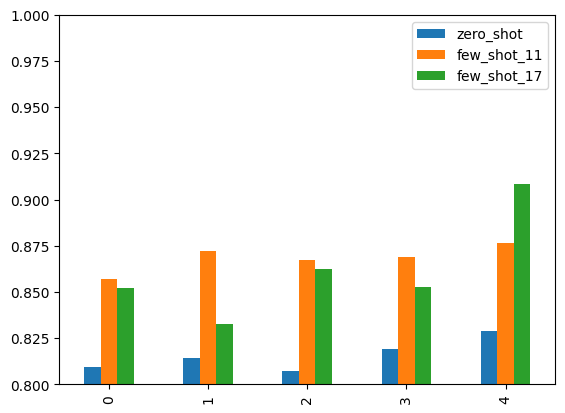

In [ ]:
model_bertscore.plot(kind='bar', ylim=[0.8, 1])